<a href="https://colab.research.google.com/github/tzlilLV97/Mission1DeepLearning/blob/main/Final_Feldman_Mission_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alon Feldman 312213135**

**Tzlil lev-or 318646510**

# Assignment 2: Word Prediction

**Deadline**: Sunday, December 11th, by 8pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

 

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three.  
In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that you properly explain what you are doing and why.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data (18%)

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [ ]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/raw_sentences.txt' # TODO - UPDATE ME!

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [ ]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)
print(sentences[0:3])

[['no', ',', 'he', 'says', 'now', '.'], ['and', 'what', 'did', 'he', 'do', '?'], ['the', 'money', "'s", 'there', '.']]


There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [ ]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [ ]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 3%

**Display** 10 sentences in the training set.
**Explain** how punctuations are treated in our word representation, and how words
with apostrophes are represented.

In [ ]:
# Your code goes here
train[10:20]


[['but', 'for', 'me', ',', 'now', ',', 'this', 'is', 'it', '.'],
 ['she', "'s", 'still', 'there', 'for', 'us', '.'],
 ['it', "'s", 'part', 'of', 'this', 'game', ',', 'man', '.'],
 ['it', 'was', ':', 'how', 'do', 'we', 'get', 'there', '?'],
 ['but', 'they', 'do', 'nt', 'last', 'too', 'long', '.'],
 ['more', 'are', 'like', 'me', ',', 'she', 'said', '.'],
 ['who', 'do', 'you', 'think', 'they', 'want', 'to', 'be', 'like', '?'],
 ['no', ',', 'he', 'could', 'not', '.'],
 ['so', 'i', 'left', 'it', 'up', 'to', 'them', '.'],
 ['we', 'were', 'nt', 'right', '.']]

**Write your answers here:**
We can see that punctuations treated as words - i.e in word repersentaion a punctuation is word. -> "me, now " -> ["me", "," ,"now"].
A words with apostrophes are seperated to 2 word by the location of the punctuation mark- i.e first word from the start to the 1 letter before the punctuation mark, and the second word from the letter after (and in some example we found in the data, include the mark) the punctuation mark  to the end of the word -> "it 's" , "do nt"-> ["it"," 's"] , ["do","nt"].

### Part (b) -- 4%

**Print** the 10 most common words in the vocabulary and how often does each of these
words appear in the training sentences. Express the second quantity as a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are useful quantities to compute, because one of the first things a machine learning model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

In [ ]:
# Your code goes here
words=[item for sub in sentences for item in sub] 
trainingWord=[item for sub in train for item in sub] 
N=len(trainingWord)

counterWord = collections.Counter(words)
counterTrain = collections.Counter(trainingWord)

theCommonGround=counterWord.most_common(10)
theCommonTrain=[]
for val in theCommonGround:
  theCommonTrain.append((val[0],counterTrain[val[0]]))
print("The Most 10 common in vocabulary : ")
print(theCommonGround)
print("\n% Occurances in train set of this 10 most common:") 
percentageArray=[(theCommonTrain[i][0],round((theCommonTrain[i][1]/N * 100),2)) for i in range(len(theCommonTrain))]
print(percentageArray)



The Most 10 common in vocabulary : 
[('.', 80974), ('it', 29200), (',', 24583), ('i', 22267), ('do', 20245), ('to', 19537), ('nt', 16460), ('?', 16210), ('the', 15939), ('that', 15795)]

% Occurances in train set of this 10 most common:
[('.', 10.7), ('it', 3.85), (',', 3.25), ('i', 2.94), ('do', 2.69), ('to', 2.58), ('nt', 2.16), ('?', 2.14), ('the', 2.09), ('that', 2.09)]


### Part (c) -- 11%

Our neural network will take as input three words and predict the next one. Therefore, we need our data set to be comprised of seuqnces of four consecutive words in a sentence, referred to as *4grams*. 

**Complete** the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other, where $N$ is the number of 4grams (sequences of 4 words appearing one after the other) that can be found in the complete list of sentences. Examples of how these functions should operate are detailed in the code below. 

You can use the defined `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [ ]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """

    # Write your code here
    arr=sents
    for i in range(len(sents)):
      for j in range(len(sents[i])):
        arr[i][j]=vocab_stoi[sents[i][j]]
    return arr

print(convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']]))

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    # Write your code here
    arr=[]
    for i in range(len(seqs)):
      for j in range(len(seqs[i])):
        if (len(seqs[i])-j)>=4:
          arr.append(seqs[i][j:j+4])
    return arr

def generate_3grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 3-grams (three consequentively occuring words)
    that appear in the sentences. Note that a unique 3-gram can appear multiple
    times, one per each time that the 3-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_3grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_3grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    # Write your code here
    arr=[]
    for i in range(len(seqs)):
      for j in range(len(seqs[i])):
        if (len(seqs[i])-j)>=3:
          arr.append(seqs[i][j:j+3])
    return arr



def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

# We can now generate our data which will be used to train and test the network
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

[[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]


## Question 2. A Multi-Layer Perceptron (44%)

In this section, we will build a two-layer multi-layer perceptron. 
Our model will look like this:

<img src="https://drive.google.com/uc?id=15uMLB-YsMHSOr0EQfTRhWd4o9enIOjUe">

Since the sentences in the data are comprised of $250$ distinct words, our task boils down to claissfication where the label space $\mathcal{S}$ is of cardinality $|\mathcal{S}|=250$ while our input, which is comprised of a combination of three words, is treated as a vector of size $750\times 1$ (i.e., the concatanation of three one-hot $250\times 1$ vectors).

The following function `get_batch` will take as input the whole dataset and output a single batch for the training. The output size of the batch is explained below.

**Implement** yourself a function `make_onehot` which takes the data in index notation and output it in a onehot notation.

Start by reviewing the helper function, which is given to you:

In [ ]:
def make_onehot(data):
    """
    Convert one batch of data in the index notation into its corresponding onehot
    notation. Remember, the function should work for both xt and st. 
     
    input - vector with shape D (1D or 2D)
    output - vector with shape (D,250)
    """
    # Write your code here
    if data.ndim==2:   #check if data shape is 2D or 1D
      temp = np.zeros((np.shape(data)[0],np.shape(data)[1],250))
      for i in range(len(data)):    
          for j in range(len(data[i])):
            temp[i][j] = np.eye(len(vocab))[data[i][j]] #create one_hot with '1'
    else:                                                # in the rigth index
      temp = np.zeros((len(data),250))
      for i in range(len(data)):
          temp[i] = np.eye(len(vocab))[data[i]] 
    return temp

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xt, st) where:
     - `xt` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `st` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xt = data[range_min:range_max, :3]
    xt = make_onehot(xt)
    st = data[range_min:range_max, 3]
    if onehot:
        st = make_onehot(st).reshape(-1, 250)
    return xt, st


### Part (a) -- 8%

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 

**Complete** the `forward` function below:

In [ ]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden

 # TODO: complete this function 
    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        inp1 = self.layer1(inp)
        return self.layer2(inp1)
        # Note that we will be using the nn.CrossEntropyLoss(),
        # which computes the softmax operation internally, as loss criterion


### Part (b) -- 10%

We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.

**Complete** the function `run_pytorch_gradient_descent`, and use it to train your PyTorch MLP model.

**Obtain** a training accuracy of at least 35% while changing only the hyperparameters of the train function.

Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

In [ ]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xt, st = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xt))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == st)
        N += st.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xt, st = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xt = torch.Tensor(xt)
            st = torch.Tensor(st).long()
            zs =  model(xt)          # compute prediction logit
            loss = criterion(zs,st)  # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs

def prepare_data(sents):
    ##prepare the data for prediction - convert the array into one hot and 3gram
    indices = convert_words_to_indices(sents)
    threegrams = generate_3grams(indices)
    return make_onehot(np.array(threegrams))

def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# In this section we test alot of hyperParameters, finally we choose 
# this: batch_size=1500, learning_rate=0.001, weigth_decay=0.0001
# with the defaulte number of max_iters

# pytorch_mlp = PyTorchMLP()
# learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp
#                                                    , batch_size=1500,
#                                                      learning_rate=0.001,
#                                                      weight_decay=0.0001)
                            
# plot_learning_curve(*learning_curve_info)

#This section just to show how we search:
# i=2
# mu=[i/1000 for i in range(1,20,5)]
# decayArray=[0.0001,0.01,0.5,0.9, 0]
# for batch in range(1500,10,-500):
#   for m in mu:
#     for decay in decayArray:
#       i+=1
#       print(f"#{i}: batch size={batch}, learning rate={m}, decay rate={decay/10}")
#       pytorch_mlp = PyTorchMLP()

#       learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp, batch_size=batch,
#                                  learning_rate=m,
#                                  weight_decay=decay,
#                                  checkpoint_path='/content/gdrive/MyDrive/Colab Notebooks/%dckpt-{}.pk'%(i))

#       plot_learning_curve(*learning_curve_info)

pytorch_mlp = PyTorchMLP()
pytorch_mlp.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/3ckpt-1000.pk'))


<All keys matched successfully>

**batch_size=1500, learning_rate=0.001, weigth_decay=0.0001**

Iter 1000. [Val Acc 34%] [Train Acc 35%, Loss 2.688118]


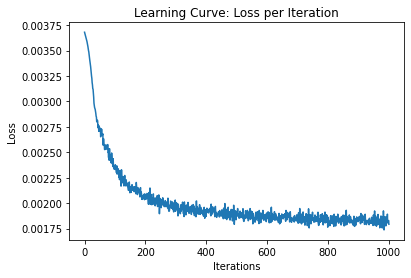


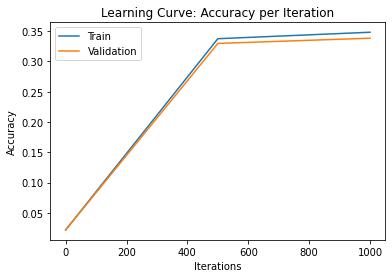

### Part (c) -- 10%
**Write** a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.
 

In [ ]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """

    global vocab_stoi, vocab_itos,vocab
    #  Write your code here
    # make the data ready to prediction i.e take 3 last word, convert them to indexes and then to oneHot vector:
    temp=[sentence[-3:]]
    convertedSentence=convert_words_to_indices(temp)
    oneHotSentence=make_onehot(np.asarray(convertedSentence))
    toBePredicted = torch.Tensor(oneHotSentence) 
    prediction = model(toBePredicted)
    argMax = np.argmax(prediction.detach().numpy())    #take the index of the word with the max probability 
    return vocab_itos[argMax]    #return the word (not the index)


make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])

'good'

### Part (d) -- 10%

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense?

In many cases where you overfit the model can either output the same results for all inputs or just memorize the dataset. 

**Print** the output for all of these sentences and 
**Write** below if you encounter these effects or something else which indicates overfitting, if you do train again with better hyperparameters.




In [ ]:
targets = ["you are a".split(),"few companies show".split(), \
           "there are no".split(), "yesterday i was".split(),\
           "the game had".split(), "yesterday the federal".split()]
print(targets)
for target in targets:
 word=make_prediction_torch(pytorch_mlp,target)
 print(" ".join(target)+" "+word)



[['you', 'are', 'a'], ['few', 'companies', 'show'], ['there', 'are', 'no'], ['yesterday', 'i', 'was'], ['the', 'game', 'had'], ['yesterday', 'the', 'federal']]
you are a good
few companies show .
there are no other
yesterday i was nt
the game had to
yesterday the federal way


**Write your answers here:**
As we can see, the model complete each sentence with different word.
Most of the sentence make sense, although the second sentence was completed with
the word "**.**" (the most common word in our vocab) and that the last one, "yesterday the federal **way**" (no make much sence).
Despite all this, we think our model don't got overfitting becasue most of the predictions does make sense and as we can see in the plot of learning curve- the gap between Train_acc and Validation_acc is not big. 
It can be the model is underfitting (so he complete one of the preditions with the most common one) because this nerual network has no activation function- only linear transform.

### Part (e) -- 6%

Report the test accuracy of your model
**33.98392652123995**

In [ ]:
print(estimate_accuracy_torch(pytorch_mlp,test4grams)*100)

33.98392652123995


## Question 3. Learning Word Embeddings (24 %)

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://drive.google.com/uc?id=16lXygLTSuRgOCj6UWK0vHkSoyRJWfMSZ" />
 

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.
 

### Part (a) -- 10%

The PyTorch model is implemented for you. Use 
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.


In [ ]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)

pytorch_wordemb= PyTorchWordEmb()
#The best resulte we got with this HyperParameters:
# result = run_pytorch_gradient_descent(pytorch_wordemb, batch_size=1500,
#                                       learning_rate=0.001,
#                                       weight_decay=0.0001,
#                                       max_iters=10000,
#                                       checkpoint_path=
#                       '/content/gdrive/MyDrive/Colab Notebooks/2Embckpt-{}.pk')

# plot_learning_curve(*result)
pytorch_wordemb.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/2Embckpt-10000.pk'))


<All keys matched successfully>

**batch_size=1500, learning_rate=0.001, weight_decay=0.0001, max_iters=10000**


Iter 10000. [Val Acc 38%] [Train Acc 40%, Loss 2.383816]


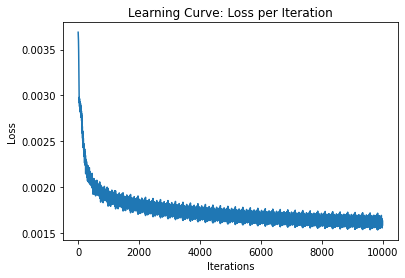



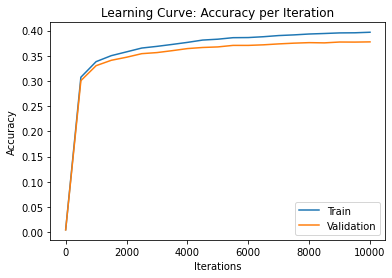

### Part (b) -- 10%

Use the function `make_prediction` that you wrote earlier to predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

**Print** the output for all of these sentences using the new network and 
**Write** below how the new results compare to the previous ones.

Just like before, if you encounter overfitting,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [ ]:
# Your code goes here

print(targets)
for target in targets:
 word=make_prediction_torch(pytorch_wordemb,target)
 print(" ".join(target)+" "+word)


[['you', 'are', 'a'], ['few', 'companies', 'show'], ['there', 'are', 'no'], ['yesterday', 'i', 'was'], ['the', 'game', 'had'], ['yesterday', 'the', 'federal']]
you are a good
few companies show .
there are no other
yesterday i was nt
the game had to
yesterday the federal government


**Write your explanation here:**$$$$  
Our model predictaion:  **------------**   The wordemb prediction:
*   you are a good     **----------------------**      same
*   few companies show .  **-------------**        same                    
*   there are no other  **------------------**        same
*   yesterday i was nt  **------------------**        same
*   the game had to     **--------------------**        same
*   yesterday the federal way **----------**   NOT the same-> **government** instead of **way**

The same beside the last sentence- now the predition for the last sentence make much more sense (as we expected the woremb  better than the previous network).








### Part (c) -- 4%

Report the test accuracy of your model  **38.06074522492433**

In [ ]:
# Write your code here
print(estimate_accuracy_torch(pytorch_wordemb,test4grams)*100)

38.06074522492433


## Question 4. Visualizing Word Embeddings (14%)

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings, which are a key concept in natural language processing.




### Part (a) -- 4%

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T
word_emb[vocab_stoi["any"],:]



array([-7.7749434e-15,  4.8366553e-01, -4.3311643e-06, -7.8874097e-28,
       -1.0215739e-03, -1.4105054e-04, -5.9137577e-03, -6.2717375e-04,
       -2.1808295e-04, -1.1453279e-03, -2.2192144e-06, -5.4619665e-04,
       -1.5425213e-09, -6.0571330e-03, -2.0001370e-04, -1.0230068e-18,
       -4.8078177e-04, -1.9489159e-10, -2.5738281e-08, -1.1997561e-12,
       -1.8250013e-03,  3.8496599e-01,  4.1873634e-01, -2.2132542e-23,
       -3.3063841e-26,  3.6174220e-01, -5.4829300e-28,  4.3336350e-01,
       -2.4898160e-05, -8.5002514e-14, -9.4143756e-15, -2.0909179e-03,
        7.7119899e-01, -2.9928817e-17,  1.0173609e+00,  4.4386429e-01,
       -2.0299671e-33, -5.4705046e-10,  2.2708751e-02, -9.4658494e-30,
       -1.1121028e-08, -3.3185119e-04, -1.3324678e-06,  1.8483503e-01,
       -2.4138125e-04, -1.0242750e-02, -4.0128906e-08,  3.6833709e-01,
       -4.7425842e-03, -8.5355001e-17, -2.2415396e-12, -4.5127282e-03,
       -1.8509469e-29, -4.7255963e-24, -1.4466282e-13, -1.4459386e-12,
      

**Write your explanation here:**

We know that each one of the 3 word_emb_layer get as input one_hot vector (size of vocab_size - 250) and the output is vector representing
of a word (emb_size - 100) , so the size of the weights matrix $W$ is $\text{vocab_size}×\text{emb_size} ⇒ 250×100$. 

Remember the input is one_hot vector (all entries are 0 and only the entry of the word's index is 1), let us check what will be in index $i$ of the output vector: $z=σ(W^Tx) ⇒ W^Tx[i]=∑_{j=0}^{250}w^T[i][j]⋅x[j]=∑_{j=0}^{250}w[j][i]⋅ ı_{[x[j]==1]}=w[\text{word's index}][i] ⇒W^Tx=W[\text{word's index}]^T$.

So we got that the output from the &i& word in the vocabulary is the $i$ row in $W$ - we can counclude from that each row in $W$ contain  the vector representing
of a word.

### Part (b) -- 5%

One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the *cosine similarity* of
every pair of words in our vocabulary. This measure of similarity between vector ${\bf v}$ and ${\bf w}$ is defined as 
   $$d_{\rm cos}({\bf v},{\bf w}) = \frac{{\bf v}^T{\bf w}}{||{\bf v}|| ||{\bf w}||}.$$  We also pre-scale the vectors to have a unit norm, using Numpy's `norm` method.

In [ ]:
norms = np.linalg.norm(word_emb, axis=1)
norms[norms==0]=0.000001   # to normalize zeros before divide
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.44644758
0.30035537


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [ ]:
# Write your code here
#For each word, we take argsort() of the matching line in 
# similarities (line=word's index), then we take the last 5 because they are the 
# largest (so they are the closest ones) but we need to remember the largest 
# will be the same word so we take [-6:-1] . Then, we print the word by passing
# the index to vocab_itos.
word_to_compute=["four","go","what","should","school","your","yesterday","not"]
for word in word_to_compute:
  order=np.argsort(similarities[vocab_stoi[word]])[-6:-1] 
  temp=[vocab_itos[index] for index in order[::-1]]
  print(f"The 5 closest words to \"{word}\" are: {temp}")

The 5 closest words to "four" are: ['three', 'five', 'several', 'two', 'million']
The 5 closest words to "go" are: ['off', 'come', 'going', 'back', 'market']
The 5 closest words to "what" are: ['who', 'while', 'how', 'where', 'when']
The 5 closest words to "should" are: ['could', 'would', 'might', 'can', 'may']
The 5 closest words to "school" are: ['life', 'music', 'yesterday', 'office', 'program']
The 5 closest words to "your" are: ['their', 'his', 'our', 'my', 'its']
The 5 closest words to "yesterday" are: ['ago', 'today', ')', 'though', 'week']
The 5 closest words to "not" are: ['nt', 'place', 'never', 'both', 'home']


**Write your explanation here:**
We can see there is logic between the word and her 5 closest ones- the network indeed find a sense relationship! 
For examle, "four" is a number, and his closest words are also a number (or a  quantity), "your" is word that "show ownership"- like "their"\"our" (his closest words).
Of course some of the logic we can't explain- such that the word ")" is closest to "yesterday" , or "not" & "home" (maybe alot of sentence has the combination "hi i am not at home"? just  hepothesis) **but** must of them did make sense! 

### Part (c) -- 5%

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment; we will cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Look at the plot and find at least two clusters of related words.

**Write** below for each cluster what is the commonality (if there is any) and if they make sense.

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


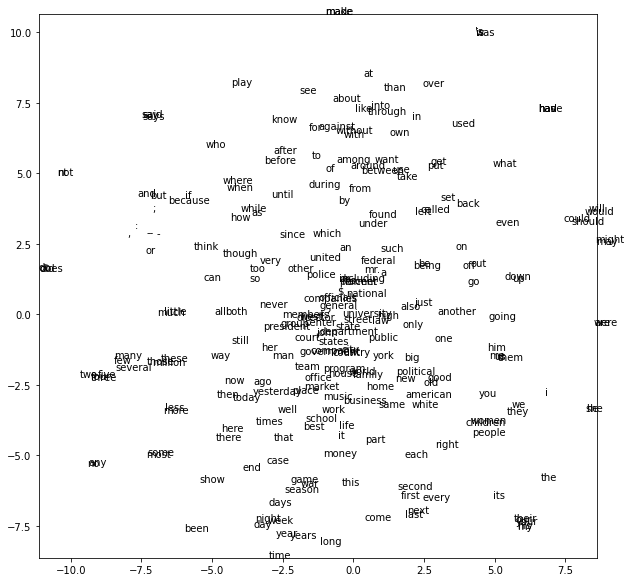

In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

**Explain and discuss your results here:**

We choose 4 red little clusters:


*   direction- down,up
*   oreder- first, second,last, every, next
*   amount- many, few, several 
*   comparison- less, more

Furthermore, we choose 3 blue largest clusters:

*   bottom left- timing- week, years, time, season. day&nigth...
*   middle  -people describes -i, him, you, we , they...
*   up rigth- auxiliary verbs- could,would,should,might...

We can see many more clusters but we hope the examples we mentioned here are enough.

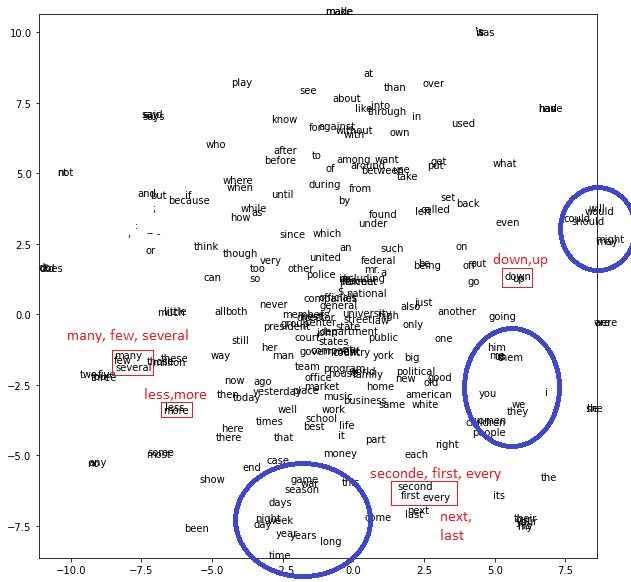

